# Imports

In [270]:
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import great_expectations as ge
import pandas as pd
import seaborn as sns

# Exploratory Data Analysis

In [271]:
df_ratings = pd.read_csv(".\\ml-latest-small\\ratings.csv")#.drop(columns=["timestamp"])
print(df_ratings.shape)
print(df_ratings.info())
df_ratings.head()

(100836, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [272]:
df_movies = pd.read_csv(".\\ml-latest-small\\movies.csv")
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [273]:
df_tags = pd.read_csv(".\\ml-latest-small\\tags.csv")#.tag.str.lower().value_counts(dropna=False).sort_values(ascending=False)
# df_tags.drop(columns=["timestamp"], inplace=True)
df_tags.sample(3)

,userId,movieId,tag,timestamp
289,62,114180,unexplained,1525554473
1542,474,2006,California,1138031745
1541,474,1997,demons,1137368191


In [274]:
n_ratings = len(df_ratings)
n_movies = df_ratings['movieId'].nunique()
n_users = df_ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


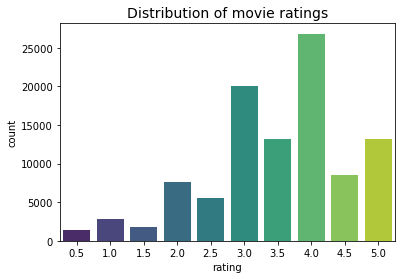

In [275]:
sns.countplot(x="rating", data=df_ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [276]:
print(f"Mean global rating: {round(df_ratings['rating'].mean(),2)}.")
mean_ratings = df_ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.5.
Mean rating per user: 3.66.


In [277]:
movie_ratings = df_ratings.merge(df_movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: title, dtype: int64

In [278]:
mean_ratings = df_ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
df_movies[df_movies['movieId']==lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [279]:
highest_rated = mean_ratings['rating'].idxmax()
df_movies[df_movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [280]:
df_ratings[df_ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


In [281]:
# Bayesian Average to take into consideration number of ratings
# Movies with small number of ratings but high ratings skew the dataset
movie_stats = df_ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


In [282]:
bayesian_avg_ratings = df_ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [283]:
movie_stats = movie_stats.merge(df_movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


In [284]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


In [285]:
# Check NaN's
df_ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

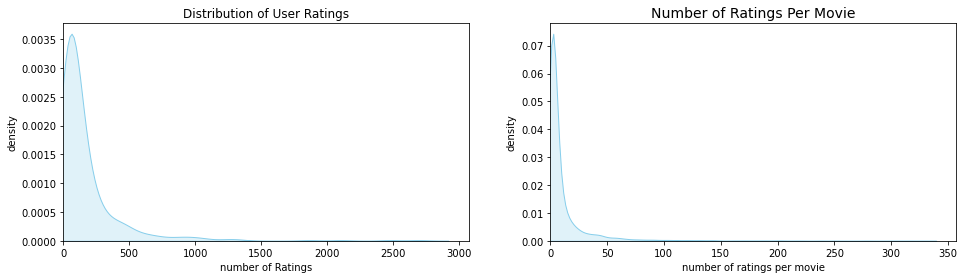

In [286]:
df_plot = df_ratings.groupby(["userId"]).agg(num_ratings=("rating", "count")).reset_index()
df_plot["userId"] = df_plot["userId"].astype(str)

df_plot2 = df_ratings.merge(df_movies, on='movieId').groupby(["movieId"]).agg(num_ratings=("rating", "count")).reset_index()
df_plot2["movieId"] = df_plot2["movieId"].astype(str)


plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(df_plot['num_ratings'], fill=True, color="skyblue")
plt.xlim(0)
plt.title('Distribution of User Ratings')
plt.xlabel('number of Ratings')
plt.ylabel('density')

plt.subplot(1,2,2)
sns.kdeplot(df_plot2['num_ratings'], fill=True, color="skyblue")
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

In [287]:
# distribution of ratings per user
df_plot = df_ratings.groupby(["userId"]).agg(num_ratings=("rating", "count")).reset_index().sort_values(by="num_ratings", ascending=False).head(20)
df_plot["userId"] = df_plot["userId"].astype(str)
fig = px.bar(df_plot, x='userId', y='num_ratings', text_auto=True)
fig.show()

In [288]:
# distribution of ratings per movie
df_plot = df_ratings.groupby(["movieId"]).agg(num_ratings=("rating", "count")).reset_index().sort_values(by="num_ratings", ascending=False).head(20)
df_plot["movieId"] = df_plot["movieId"].astype(str)
fig = px.bar(df_plot, x='movieId', y='num_ratings', text_auto=True)
fig.show()

In [289]:
df_movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [290]:
df_movies["year"] = df_movies.title.str[-6:].str.replace('(', '', regex=True).str.replace(')', '', regex=True)
df_movies["title"] = df_movies["title"].str[:-6]
df_movies = df_movies[df_movies["year"].str.isdigit()]
df_movies["year"] = df_movies["year"].astype(int)
df_movies["genres"] = df_movies["genres"].str.replace("|", ", ", regex=True)
df_movies.sample(5)

,movieId,title,genres,year
3526,4818,Extreme Days,"Action, Adventure, Comedy, Drama",2001
871,1156,"Children Are Watching Us, The (Bambini ci guar...",Drama,1944
7078,69844,Harry Potter and the Half-Blood Prince,"Adventure, Fantasy, Mystery, Romance, IMAX",2009
4865,7285,Thirteen,Drama,2003
5443,26003,Night and Fog (Nuit et brouillard),"Crime, Documentary, War",1955


In [291]:
all_genres = df_movies["genres"].str.split(", ").explode()
all_genres = all_genres.value_counts(dropna=False).to_frame()
all_genres.reset_index(inplace=True)
all_genres.columns = ['genres', 'count']
fig = px.bar(all_genres, x='genres', y='count', text_auto=True)
fig.show()

In [292]:
fig = px.histogram(df_movies, x="year")
fig.show()

In [293]:
df_tags = pd.read_csv(".\\ml-latest-small\\tags.csv")#.tag.str.lower().value_counts(dropna=False).sort_values(ascending=False)
# df_tags.drop(columns=["timestamp"], inplace=True)
df_tags.sample(3)

,userId,movieId,tag,timestamp
1856,474,3983,family,1137205683
661,357,2762,twist ending,1348626913
268,62,107348,Steve Carell,1528935000


In [294]:
df_tags.isna().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [295]:
# Aggregates tags per user-movie pair in a row
df_tags = (
    df_tags.groupby(["userId", "movieId"])["tag"]
    .apply(", ".join)
    .reset_index()
    .rename(columns={"tag": "user_movie_tags"})
)
df_tags["user_movie_tags"] = df_tags["user_movie_tags"].str.lower()
df_tags.sample(5)

,userId,movieId,user_movie_tags
174,327,2616,comic book
535,474,1081,cross dressing
899,474,3030,samurai
1233,474,6385,girl power
768,474,2108,weather forecaster


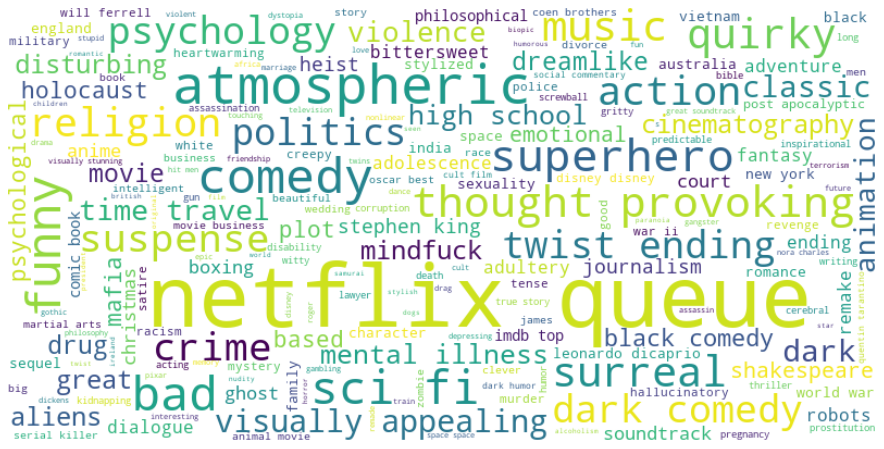

In [296]:
all_tags = df_tags["user_movie_tags"].str.split("|").explode()
tag_text = " ".join(all_tags)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(tag_text)
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [297]:
# opted not to use this dataset because IMDB API is not free and TMDB API is not free for commercial use
pd.read_csv(".\\ml-latest-small\\links.csv").sample(2)

,movieId,imdbId,tmdbId
1587,2126,120832,8688.0
6586,55269,838221,4538.0


# Join Data

In [298]:
df_ratings_tags = (
    df_ratings.drop(columns="timestamp")
    .merge(
        df_tags, 
        on=["userId", "movieId"], 
        how="left"
    )
)
df_ratings_tags.sample(5)

,userId,movieId,rating,user_movie_tags
38246,263,163,4.0,NaN
93466,599,2617,3.0,NaN
18132,114,8961,3.5,NaN
29130,200,5139,3.0,NaN
94175,599,6731,1.5,NaN


In [299]:
df_ratings_tags.isna().sum()

userId                 0
movieId                0
rating                 0
user_movie_tags    99201
dtype: int64

In [300]:
df_ratings_tags.user_movie_tags.fillna(value="No tags", inplace=True)

In [301]:
df_preprocess = df_ratings_tags.merge(df_movies, on="movieId", how='left')

In [302]:
df_preprocess.isna().sum()

userId              0
movieId             0
rating              0
user_movie_tags     0
title              31
genres             31
year               31
dtype: int64

In [303]:
df_preprocess.dropna(subset=["title", "genres", "year"], inplace=True) # small proportion so it is safe to drop

In [304]:
df_preprocess.isna().sum()

userId             0
movieId            0
rating             0
user_movie_tags    0
title              0
genres             0
year               0
dtype: int64

In [305]:
df_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100805 entries, 0 to 100835
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   userId           100805 non-null  int64  
 1   movieId          100805 non-null  int64  
 2   rating           100805 non-null  float64
 3   user_movie_tags  100805 non-null  object 
 4   title            100805 non-null  object 
 5   genres           100805 non-null  object 
 6   year             100805 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 6.2+ MB


In [306]:
df_preprocess.head()

,userId,movieId,rating,user_movie_tags,title,genres,year
0,1,1,4.0,No tags,Toy Story,"Adventure, Animation, Children, Comedy, Fantasy",1995.0
1,1,3,4.0,No tags,Grumpier Old Men,"Comedy, Romance",1995.0
2,1,6,4.0,No tags,Heat,"Action, Crime, Thriller",1995.0
3,1,47,5.0,No tags,Seven (a.k.a. Se7en),"Mystery, Thriller",1995.0
4,1,50,5.0,No tags,"Usual Suspects, The","Crime, Mystery, Thriller",1995.0


# Data Quality

In [307]:
# Data quality checks with great expectations
ge_df = ge.from_pandas(df_preprocess)
ge_df.expect_column_values_to_not_be_null("userId")
ge_df.expect_column_values_to_not_be_null("movieId")
ge_df.expect_column_values_to_not_be_null("rating")
ge_df.expect_column_values_to_not_be_null("year")
ge_df.expect_column_values_to_not_be_null("title")
ge_df.expect_column_values_to_not_be_null("genres")
ge_df.expect_column_values_to_be_between("rating", min_value=0, max_value=5)
ge_df.expect_column_values_to_be_between("year", min_value=1900, max_value=2100)
ge_df.expect_column_values_to_not_be_null("title")
ge_df.expect_column_values_to_match_regex("genres", r"^[\w, ]*$", mostly=0.8)
ge_df.expect_table_row_count_to_be_between(1, len(df_preprocess))
ge_df["user_item_rating"] = (
    ge_df["userId"].astype(str) + "_" +
    ge_df["movieId"].astype(str) + "_" +
    ge_df["rating"].astype(str)
)
ge_df.expect_column_values_to_be_unique("user_item_rating")
validation_results = ge_df.validate()
print(validation_results)

{
  "success": true,
  "results": [
    {
      "success": true,
      "expectation_config": {
        "expectation_type": "expect_column_values_to_not_be_null",
        "kwargs": {
          "column": "userId",
          "result_format": "BASIC"
        },
        "meta": {}
      },
      "result": {
        "element_count": 100805,
        "unexpected_count": 0,
        "unexpected_percent": 0.0,
        "unexpected_percent_total": 0.0,
        "partial_unexpected_list": []
      },
      "meta": {},
      "exception_info": {
        "raised_exception": false,
        "exception_message": null,
        "exception_traceback": null
      }
    },
    {
      "success": true,
      "expectation_config": {
        "expectation_type": "expect_column_values_to_not_be_null",
        "kwargs": {
          "column": "movieId",
          "result_format": "BASIC"
        },
        "meta": {}
      },
      "result": {
        "element_count": 100805,
        "unexpected_count": 0,
        "un

In [308]:
df_preprocess.drop("user_item_rating", axis=1, inplace=True)
df_preprocess.to_csv("clean_movies_data.csv", index=False)

There are not missing values in ratings. A few possibe strategies to deal with missing ratings are:
* drop rows with missing ratings if they represent a small proportion of the dataset
* impute missing ratings with mean or median rating per movie, user, genre or overall
* use a model that can handle missing values like matrix factorization, KNN 